In [1]:
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm

from datasets.graph import draw_sample
import torch
import torch_geometric
import torch
import os
import os.path as osp


In [2]:
import glob
raw_dir= '/home/sameasy2006/npz_hgcal_pionaddsiminfo_all_k8/pion_hgctup_0to1000/clusters/'
fnamelist = [filepath for filepath in glob.glob(raw_dir+'data_*.pt')]
data_list = []
for i in tqdm(fnamelist):
    data_list.append(torch.load(i))
    
print((data_list[0].y))
print(data_list[0].pos)
print(len(data_list))
totalev = len(data_list)
#trainev = 

/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



tensor([116.2030])
None
8383


In [3]:
import torch_geometric
ntrainbatch = 50
ntestbatch = 1
trainloader = torch_geometric.data.DataLoader(data_list[:totalev-300], batch_size=ntrainbatch)
testloader = torch_geometric.data.DataLoader(data_list[totalev-300:totalev], batch_size=ntestbatch)

In [4]:
import os
import os.path as osp
import math

import numpy as np
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv, NNConv
#from torch_geometric.nn.pool.edge_pool import EdgePooling

from torch_geometric.utils import normalized_cut
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils.undirected import to_undirected
from torch_geometric.nn import (graclus, max_pool, max_pool_x,
                                global_mean_pool, global_max_pool,
                                global_add_pool)

transform = T.Cartesian(cat=False)

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

class DynamicReductionNetwork(nn.Module):
    # This model iteratively contracts nearest neighbour graphs 
    # until there is one output node.
    # The latent space trained to group useful features at each level
    # of aggregration.
    # This allows single quantities to be regressed from complex point counts
    # in a location and orientation invariant way.
    # One encoding layer is used to abstract away the input features.
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add',
                 norm=torch.tensor([1./500., 1./500., 1./54., 1/25., 1./1000.])):
 #                norm=torch.tensor([1., 1., 1., 1., 1.])):
        super(DynamicReductionNetwork, self).__init__()

        self.datanorm = nn.Parameter(norm)
        
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2

        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, 2*hidden_dim),            
            nn.ELU(),
            nn.Linear(2*hidden_dim, 2*hidden_dim),
            nn.ELU(),
            nn.Linear(2*hidden_dim, 2*hidden_dim),
            nn.ELU(),
            nn.Linear(2*hidden_dim, hidden_dim),#added
            nn.ELU(),#added
        )        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        
        convnn3 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
                
        self.edgeconv1 = EdgeConv(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv(nn=convnn2, aggr=aggr)
        self.edgeconv3 = EdgeConv(nn=convnn2, aggr=aggr)
        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.ELU(),
                                    #nn.Softplus(),
#                                    nn.Linear(hidden_dim//2, hidden_dim//2),#added
#                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim//2, output_dim)
                                   )
        
        
    def forward(self, data):        
        data.x = self.datanorm * data.x
        data.x = self.inputnet(data.x)
        
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv1(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data)
        
        ####
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv3(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data)
        ####
        
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv2.flow))
        data.x = self.edgeconv2(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        x, batch = max_pool_x(cluster, data.x, data.batch)

        x = global_max_pool(x, batch)
#        print(self.output(x))
        return self.output(x).squeeze(-1)


In [5]:
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from tqdm import tqdm_notebook as tqdm


#from models.DynamicReductionNetwork import DynamicReductionNetwork

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drn = DynamicReductionNetwork()
        
    def forward(self, data):
        logits = self.drn(data)
        return F.softplus(logits)
        #return logits
device = torch.device('cuda')#('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
#criterion = torch.nn.MSELoss()


def resoloss(output,truth):
    batch_size = output.size()[0]
    mse = F.mse_loss(output, truth, reduction='mean')
    res = torch.sum((output-truth)**2/truth)/batch_size
    #return (mse + 0.2*res)
    return (res)
    



model.train()
def train(epoch):
    model.train()
    loss = []
    for data in tqdm(trainloader):
            data = data.to(device)        
            optimizer.zero_grad()
            result = model(data)
            lossc = resoloss(result, data.y)
#            mse = F.mse_loss(result, data.y, reduction='mean')
#            mse = criterion(result, data.y)
#            print('result, y:',result,data.y)
#            print('crit, orig:',criterion(result, data.y),F.mse_loss(result, data.y, reduction='mean'))
            loss.append(lossc.item()) 
            lossc.backward()
#            print(mse)
            optimizer.step()
    print( 'batches for train:',len(loss)) 
#    print('loss',loss)
    print('train loss:',np.mean(np.array(loss))) 
#    print(data)

from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy.stats as scs
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

def gaussian(x,  mean,a, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def evaluate(epoch):
        """"Evaluate the model"""
        model.zero_grad()
        torch.cuda.empty_cache()
        model.eval()
        loss = []
        frac = []
        for data in tqdm(testloader):
            data = data.to(device)        
            result = model(data)
            lossc = resoloss(result, data.y)
#            print (result.item(),data.y.item())
            frac.append((result.item() - data.y.item())/data.y.item())
            loss.append(lossc.item()) 
        
        print('batches for test:', len(loss)) 
        print('test loss:',np.mean(np.array(loss)))
        fracarr = np.array(frac)
        print('pred - true / true mean:',(np.mean(fracarr)))
        print('pred - true / true std:',(np.std(fracarr)))
        (mu, sigma) = norm.fit(fracarr)
        print('mu,sig:',mu,sigma)
        
        

        '''
        ### for normalised 
        n, bins, patches = plt.hist(fracarr, 60, normed=1, facecolor='green', alpha=0.75)
        y = scs.norm.pdf( bins, mu, sigma)
        l = plt.plot(bins, y, 'r--', linewidth=2)

        #plot
        plt.xlabel('pred - true / true')
        plt.ylabel('counts')
        plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
        plt.grid(True)

        plt.show()
        
        
        '''
        bin_heights, bin_borders, _ = plt.hist(fracarr,range=[-10,10], bins=100, label='histogram')
        bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
        
        try:
            popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 100., 1.],bounds = ([-np.inf,0,0],[np.inf,np.inf,np.inf]))
            x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 100)
            plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
            plt.legend()


            plt.xlabel('pred - true / true')
            plt.ylabel('counts')
            #plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
            plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(popt[0], popt[2]))
            plt.grid(True)

            plt.show()

        except RuntimeError:
            print("Error - curve_fit failed")
            plt.xlabel('pred - true / true')
            plt.ylabel('counts')
            #plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
            plt.title('pred - true / true fit failed')
            plt.grid(True)

            plt.show()
            
        return np.mean(np.array(loss))
        

epoch: 1


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 272.5151127473808


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 146.1333570307625
pred - true / true mean: 0.3145028331911969
pred - true / true std: 1.0699580342726671
mu,sig: 0.3145028331911969 1.0699580342726671


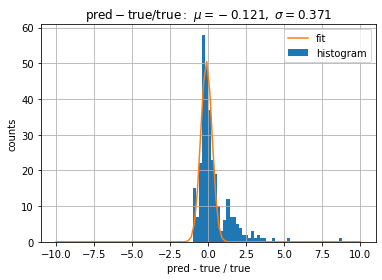

new best test loss: 146.1333570307625
epoch: 2


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 109.08505277280454


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 96.26665002591287
pred - true / true mean: -0.00031173445657043313
pred - true / true std: 0.6743634599620414
mu,sig: -0.00031173445657043313 0.6743634599620414


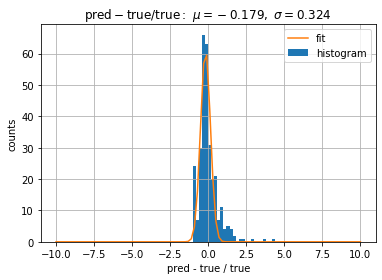

new best test loss: 96.26665002591287
epoch: 3


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 103.37575069474585


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 101.30681037273335
pred - true / true mean: 0.2891491634558616
pred - true / true std: 0.8691217821646836
mu,sig: 0.2891491634558616 0.8691217821646836


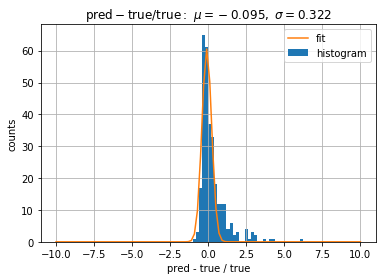

epoch: 4


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 68.56254043108152


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 70.42347912850013
pred - true / true mean: 0.2392351165941206
pred - true / true std: 0.9380463020330925
mu,sig: 0.2392351165941206 0.9380463020330925


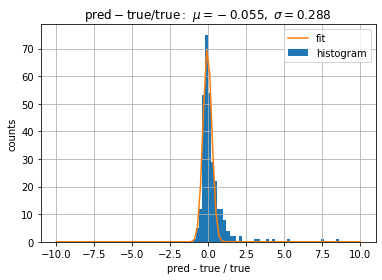

new best test loss: 70.42347912850013
epoch: 5


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 40.39709935953588


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 25.243699443151783
pred - true / true mean: 0.011664860688074008
pred - true / true std: 0.40284894151456935
mu,sig: 0.011664860688074008 0.40284894151456935


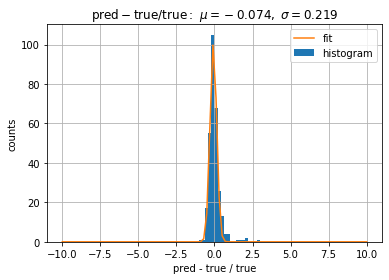

new best test loss: 25.243699443151783
epoch: 6


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 17.402175161573624


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 15.494093063465565
pred - true / true mean: 0.08830256376353605
pred - true / true std: 0.37282903504172704
mu,sig: 0.08830256376353605 0.37282903504172704


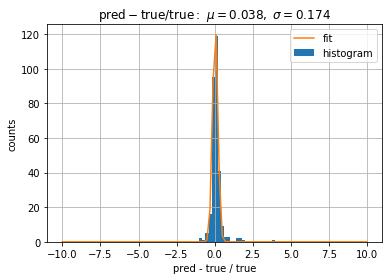

new best test loss: 15.494093063465565
epoch: 7


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 12.203140729739342


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 12.760421921073187
pred - true / true mean: 0.07537382896435861
pred - true / true std: 0.35570426398054833
mu,sig: 0.07537382896435861 0.35570426398054833


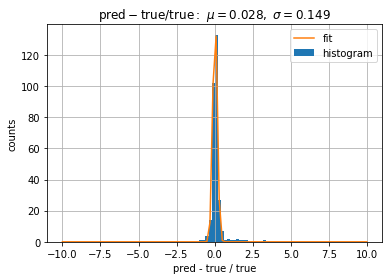

new best test loss: 12.760421921073187
epoch: 8


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 10.572844334590583


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 12.751859161517656
pred - true / true mean: 0.07639335020106967
pred - true / true std: 0.3676939919187508
mu,sig: 0.07639335020106967 0.3676939919187508


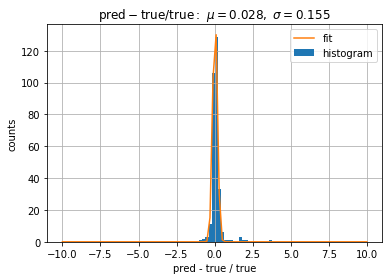

new best test loss: 12.751859161517656
epoch: 9


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 10.136619517832626


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 13.41832020219008
pred - true / true mean: 0.12455517731044438
pred - true / true std: 0.3322446289917554
mu,sig: 0.12455517731044438 0.3322446289917554


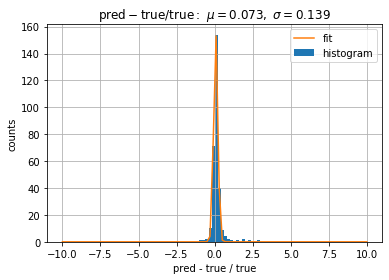

epoch: 10


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 9.26070643795861


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 11.509426056017297
pred - true / true mean: 0.08584114499417259
pred - true / true std: 0.30159662677286225
mu,sig: 0.08584114499417259 0.30159662677286225


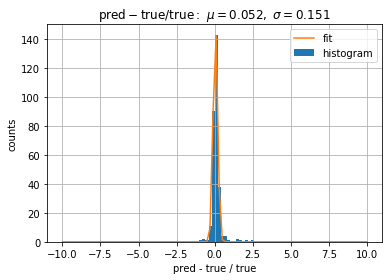

new best test loss: 11.509426056017297
epoch: 11


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 9.017717988402755


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 10.022585774745943
pred - true / true mean: 0.047918254014403236
pred - true / true std: 0.3365493942744978
mu,sig: 0.047918254014403236 0.3365493942744978


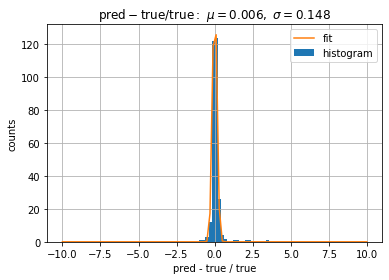

new best test loss: 10.022585774745943
epoch: 12


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 8.580771770006345


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 9.312906351021809
pred - true / true mean: 0.0007564471844871006
pred - true / true std: 0.25142151169810845
mu,sig: 0.0007564471844871006 0.25142151169810845


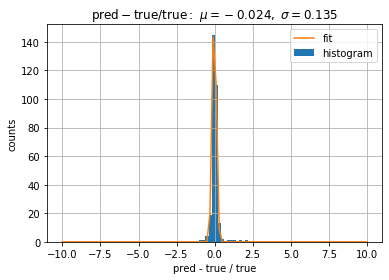

new best test loss: 9.312906351021809
epoch: 13


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 8.2626166270103


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 9.297749789225742
pred - true / true mean: -0.01516381141632504
pred - true / true std: 0.26854181465324245
mu,sig: -0.01516381141632504 0.26854181465324245


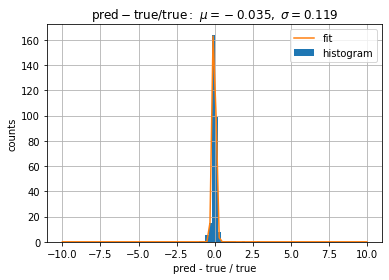

new best test loss: 9.297749789225742
epoch: 14


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 7.843218448721332


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 8.726186409925504
pred - true / true mean: 0.002534514196010599
pred - true / true std: 0.2536525754543971
mu,sig: 0.002534514196010599 0.2536525754543971


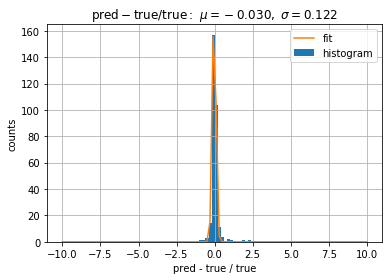

new best test loss: 8.726186409925504
epoch: 15


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 7.883597026636571


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 9.358998132926827
pred - true / true mean: -0.026859690087245484
pred - true / true std: 0.22623858570444563
mu,sig: -0.026859690087245484 0.22623858570444563


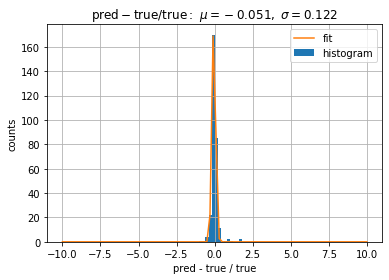

epoch: 16


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 7.804404557487111


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 9.2415985124435
pred - true / true mean: -0.0399735632113678
pred - true / true std: 0.21783099468627165
mu,sig: -0.0399735632113678 0.21783099468627165


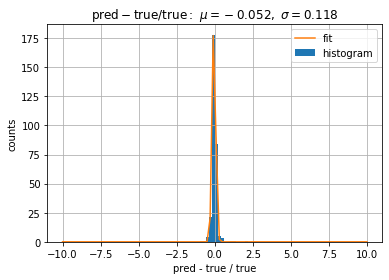

epoch: 17


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 7.463315928423846


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 9.96911054996491
pred - true / true mean: -0.04032540712023002
pred - true / true std: 0.27340192478441633
mu,sig: -0.04032540712023002 0.27340192478441633


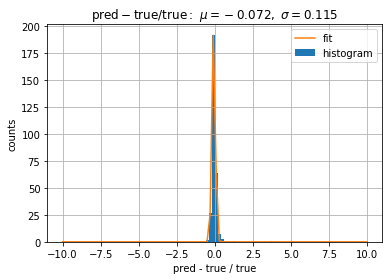

epoch: 18


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 7.178036413810871


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 9.484326780829278
pred - true / true mean: -0.041310400164142426
pred - true / true std: 0.23329719994189016
mu,sig: -0.041310400164142426 0.23329719994189016


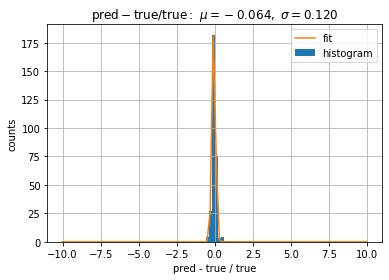

epoch: 19


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 7.187264967847754


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 8.18898842059756
pred - true / true mean: -0.01279163564466279
pred - true / true std: 0.2227955146853999
mu,sig: -0.01279163564466279 0.2227955146853999


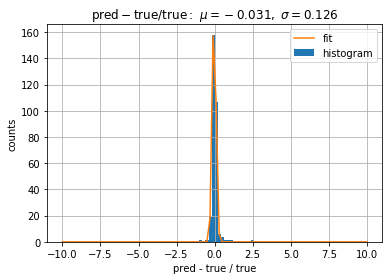

new best test loss: 8.18898842059756
epoch: 20


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.928473266554468


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 8.136558021427918
pred - true / true mean: 0.003525531181149126
pred - true / true std: 0.29051595343702696
mu,sig: 0.003525531181149126 0.29051595343702696


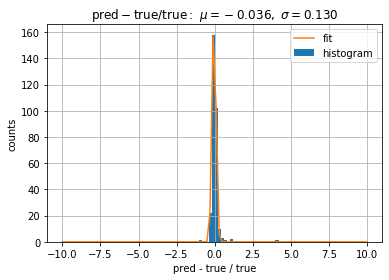

new best test loss: 8.136558021427918
epoch: 21


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.728956647125291


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 7.870388843208014
pred - true / true mean: -0.017140928053204867
pred - true / true std: 0.21005960492835457
mu,sig: -0.017140928053204867 0.21005960492835457


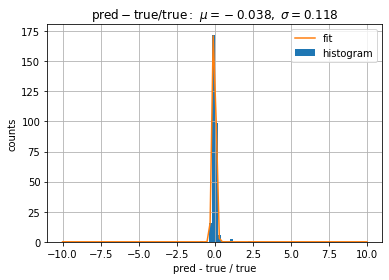

new best test loss: 7.870388843208014
epoch: 22


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.879436464957249


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 7.146893776265351
pred - true / true mean: 0.012954236221439134
pred - true / true std: 0.23342989881432685
mu,sig: 0.012954236221439134 0.23342989881432685


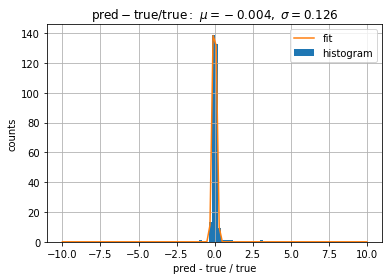

new best test loss: 7.146893776265351
epoch: 23


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.805972453252769


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 7.7772742012618865
pred - true / true mean: -0.01671320873626308
pred - true / true std: 0.21546492313932175
mu,sig: -0.01671320873626308 0.21546492313932175


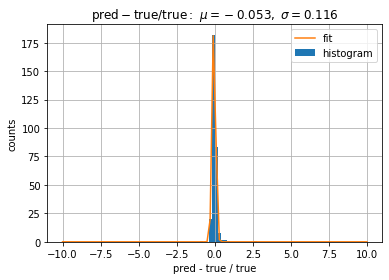

epoch: 24


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.642780567392891


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 7.412453185079454
pred - true / true mean: 0.02824923046033545
pred - true / true std: 0.30296547615172315
mu,sig: 0.02824923046033545 0.30296547615172315


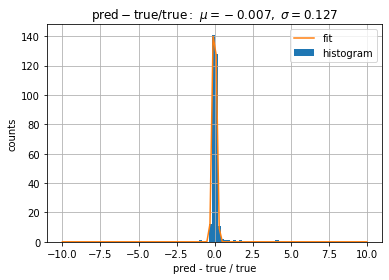

epoch: 25


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.626260187890795


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 7.218772986496915
pred - true / true mean: 0.02534108629655786
pred - true / true std: 0.24054544218795754
mu,sig: 0.02534108629655786 0.24054544218795754


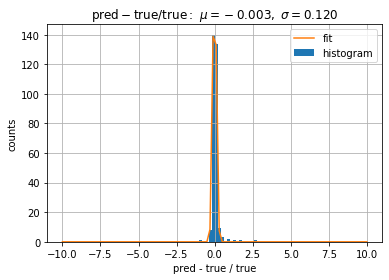

epoch: 26


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.583890089282283


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 7.322042104910749
pred - true / true mean: 0.008638514835125
pred - true / true std: 0.25329594340408296
mu,sig: 0.008638514835125 0.25329594340408296


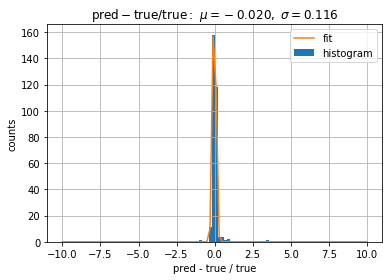

epoch: 27


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.363676321359328


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 6.9554331056948895
pred - true / true mean: 0.011923542839390058
pred - true / true std: 0.22684321477661082
mu,sig: 0.011923542839390058 0.22684321477661082


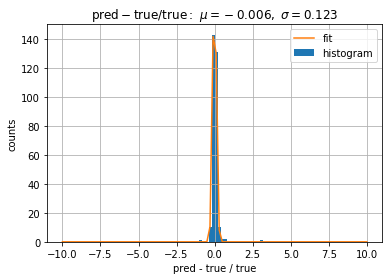

new best test loss: 6.9554331056948895
epoch: 28


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.597957447723106


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 7.070401580007965
pred - true / true mean: 0.018873644657883062
pred - true / true std: 0.24561630792644423
mu,sig: 0.018873644657883062 0.24561630792644423


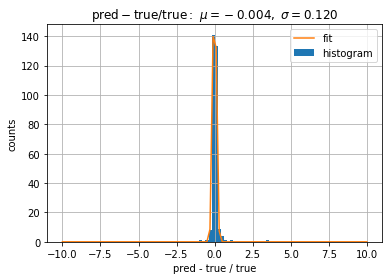

epoch: 29


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.2097220266306845


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 6.5261473577722064
pred - true / true mean: 0.028589534596779317
pred - true / true std: 0.19039797226751048
mu,sig: 0.028589534596779317 0.19039797226751048


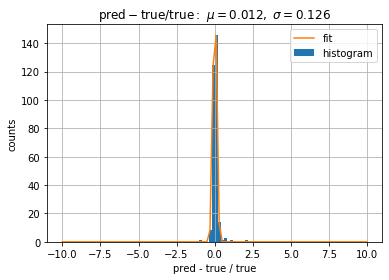

new best test loss: 6.5261473577722064
epoch: 30


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for train: 162
train loss: 6.274194034529321


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



batches for test: 300
test loss: 6.64469775709862
pred - true / true mean: 0.03132870624321137
pred - true / true std: 0.22855111623376256
mu,sig: 0.03132870624321137 0.22855111623376256


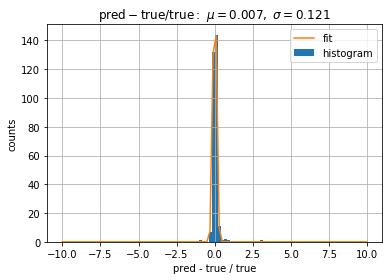

epoch: 31


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: 

In [12]:
checkpoint_dir = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/ouput_regression_testtesttesttest_inputdynaddlayer/'
os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
for epoch in range(1, 60):
    print ('epoch:',epoch)
    train(epoch)
    loss_epoch = evaluate(epoch)
    checkpoint_file = 'model_epoch_%03i.pth.tar' % ( epoch )
    torch.save(dict(model=model.state_dict()),
                   os.path.join(checkpoint_dir,checkpoint_file ))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        torch.save(dict(model=model.state_dict()),
                   os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))

In [6]:
model_fname = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/ouput_regression_testtesttesttest_inputdynaddlayer/model_checkpoint_best.pth.tar'
#model_fname = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/ouput_regression_testtesttesttest_outputaddlayer/model_epoch_019.pth.tar'

mdl=Net().to(device)
mdl.load_state_dict(torch.load(model_fname)['model'])
mdl.eval()


Net(
  (drn): DynamicReductionNetwork(
    (inputnet): Sequential(
      (0): Linear(in_features=5, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): ELU(alpha=1.0)
    )
    (edgeconv1): EdgeConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=96, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=96, out_features=64, bias=True)
      (3): ELU(alpha=1.0)
    ))
    (edgeconv2): EdgeConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=96, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=96, out_features=64, bias=True)
      (3): ELU(alpha=1.0)
    ))
    (edgeconv3): EdgeConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=96, bias=True)
      (1): ELU(a

In [7]:
#mdl.zero_grad()
torch.cuda.empty_cache()
#model.eval()
pred = []
true = []
#testloader2 = torch_geometric.data.DataLoader(data_list[totalev-3000:totalev], batch_size=1)
testloader2 = torch_geometric.data.DataLoader(data_list, batch_size=1)
for data in tqdm(testloader2):
    data = data.to(device)        
    result = F.softplus(mdl(data))
    #print(result.item())
    pred.append(result.item())
    true.append(data.y.item())
    
    
#print(pred)
#print(true)


/home/sameasy2006/miniconda3/envs/mlgnn2/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [12]:
def plotpred(pred,true,e1,e2):
#    preda = np.array(pred)
#    truea = np.array(true)
    fracarr = (pred - true)/true
    if e2<250 : 
        bin_heights, bin_borders, _ = plt.hist(fracarr,range=[-2,2], bins=20, label='histogram')
    else:
        bin_heights, bin_borders, _ = plt.hist(fracarr,range=[-1,1], bins=50, label='histogram')

    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 100., 0.1],bounds = ([-np.inf,0,0],[np.inf,np.inf,np.inf]))
    perr = np.sqrt(np.diag(pcov))
    print(popt,perr)

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 100)
    plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
    plt.legend()


    plt.xlabel('pred - true / true')
    plt.ylabel('counts')
    #plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
    plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f,\ E=$%i to %i' %(popt[0], popt[2],e1,e2))
    plt.grid(True)
    
    plt.show()
    return [popt[0], popt[2],perr[0], perr[2]]

In [33]:
'''
bins =  np.linspace(0,1000,5)
print(bins.size)
pred = np.array(pred)
true = np.array(true)
for i in range (bins.size - 1):
    preda = pred[(true >bins[i]) & (true <bins[i+1]) ]
    truea = true[(true >bins[i]) & (true <bins[i+1]) ]
    plotpred(preda,truea,bins[i],bins[i+1])
'''   

'\nbins =  np.linspace(0,1000,5)\nprint(bins.size)\npred = np.array(pred)\ntrue = np.array(true)\nfor i in range (bins.size - 1):\n    preda = pred[(true >bins[i]) & (true <bins[i+1]) ]\n    truea = true[(true >bins[i]) & (true <bins[i+1]) ]\n    plotpred(preda,truea,bins[i],bins[i+1])\n'

In [27]:
'''
plt.scatter(true, pred,alpha=0.3)#,label='uncorr')

plt.xlabel('True Values ')
plt.ylabel('Predictions ')
#plt.legend(loc='upper right')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)                                                                                                                                               
#plt.savefig('energyscatt.png')
#plt.close()
plt.show()
'''

"\nplt.scatter(true, pred,alpha=0.3)#,label='uncorr')\n\nplt.xlabel('True Values ')\nplt.ylabel('Predictions ')\n#plt.legend(loc='upper right')\nlims = [0, 1000]\nplt.xlim(lims)\nplt.ylim(lims)\n_ = plt.plot(lims, lims)                                                                                                                                               \n#plt.savefig('energyscatt.png')\n#plt.close()\nplt.show()\n"

In [28]:
'''
bins =  np.linspace(0,200,11)
bins2 = np.linspace(200,1000,6)
print(bins.size)
pred = np.array(pred)
true = np.array(true)
seoe = []
for i in range (bins.size - 1):
    preda = pred[(true >bins[i]) & (true <bins[i+1]) ]
    truea = true[(true >bins[i]) & (true <bins[i+1]) ]
    vals = plotpred(preda,truea,bins[i],bins[i+1])
    #seoe.append(vals[1]/bins[i+1])
    #print (bins[i],bins[i+1])
#seoear = np.array(seoe)
'''

'\nbins =  np.linspace(0,200,11)\nbins2 = np.linspace(200,1000,6)\nprint(bins.size)\npred = np.array(pred)\ntrue = np.array(true)\nseoe = []\nfor i in range (bins.size - 1):\n    preda = pred[(true >bins[i]) & (true <bins[i+1]) ]\n    truea = true[(true >bins[i]) & (true <bins[i+1]) ]\n    vals = plotpred(preda,truea,bins[i],bins[i+1])\n    #seoe.append(vals[1]/bins[i+1])\n    #print (bins[i],bins[i+1])\n#seoear = np.array(seoe)\n'

[   0.   20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  250.
  300.  350.  400.  450.  500.  550.  600.  650.  700.  750.  800.  850.
  900.  950. 1000.]
[ 0.1895046  35.12191476  0.37750137] [0.03031007 2.44217726 0.03031007]


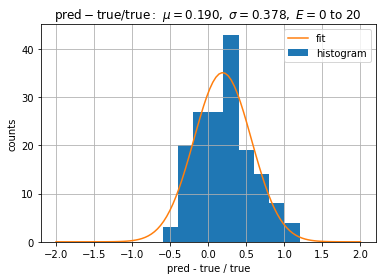

[0.18950459979129405, 0.3775013677822994, 0.030310067278760948, 0.03031006733781509]
[ 0.09285372 52.03013489  0.24647548] [0.00684056 1.25048929 0.0068397 ]


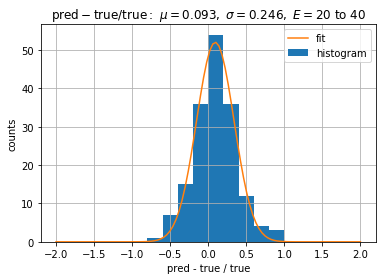

[0.09285372441833467, 0.24647548394070595, 0.006840559968859097, 0.006839695519944725]
[ 0.07894164 62.47438512  0.20907078] [0.00540349 1.39608805 0.00538494]


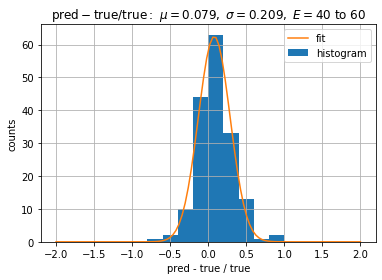

[0.07894164325123744, 0.2090707814016795, 0.005403490428759789, 0.0053849425375523275]
[4.94655357e-02 8.80130221e+01 1.58882368e-01] [0.00461671 2.21119737 0.00462625]


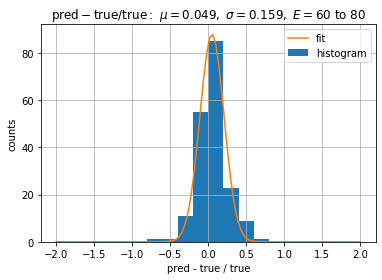

[0.04946553569305214, 0.1588823680594613, 0.004616713336119713, 0.004626248173654223]
[6.47660450e-02 1.11674166e+02 1.47061544e-01] [0.00257197 1.58150689 0.00234017]


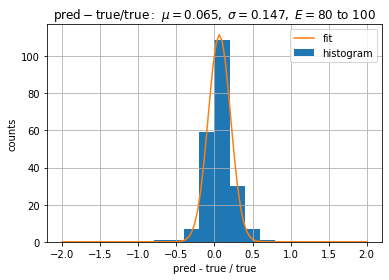

[0.06476604497592413, 0.1470615441174599, 0.002571971951997071, 0.002340172432683417]
[4.08093138e-02 1.39299155e+02 1.54165440e-01] [0.00095782 0.76819321 0.00100437]


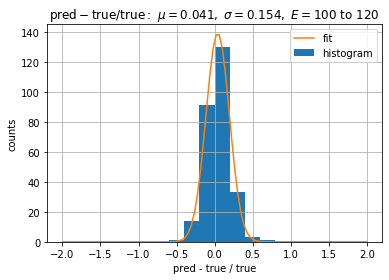

[0.04080931379749015, 0.154165440144056, 0.0009578246258798264, 0.0010043672696850676]
[4.10395355e-02 1.14401478e+02 1.43089988e-01] [0.00245539 1.7654963  0.00264817]


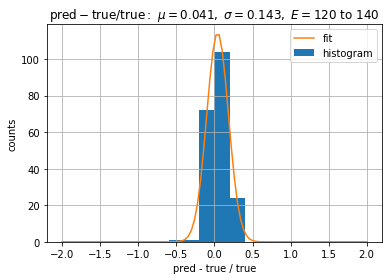

[0.04103953553144809, 0.14308998779802973, 0.0024553873201619576, 0.002648172439072437]
[3.99480872e-02 1.13256672e+02 1.51309044e-01] [0.00235253 1.57363463 0.00249677]


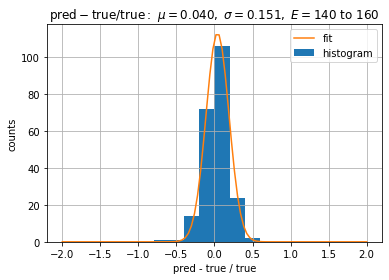

[0.03994808723644773, 0.15130904406078705, 0.0023525308205640024, 0.0024967702756062402]
[1.40185654e-02 1.10646701e+02 1.29510682e-01] [1.67768991e-03 1.86132063e+00 2.80849761e-03]


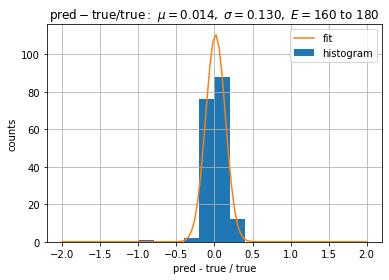

[0.014018565428277988, 0.129510682291116, 0.0016776899070944887, 0.002808497614009906]
[7.86223752e-03 8.36881192e+01 1.40773489e-01] [0.00118158 0.77791567 0.00167283]


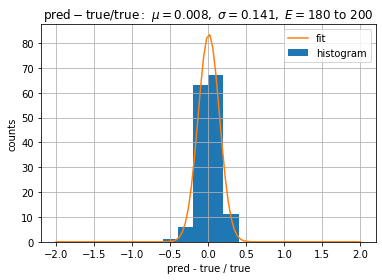

[0.007862237519425332, 0.14077348854871038, 0.0011815842524668275, 0.0016728325700538164]
[1.62288884e-02 7.30679001e+01 1.02471991e-01] [0.00264905 1.63584605 0.00264905]


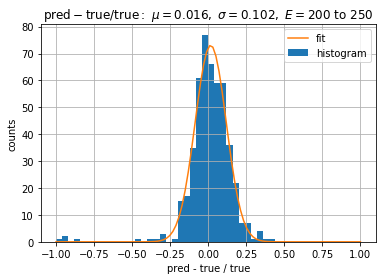

[0.016228888448507773, 0.10247199066369578, 0.0026490512483264613, 0.0026490512445030913]
[2.13713195e-02 7.15168333e+01 9.77661780e-02] [0.00268088 1.69835474 0.00268088]


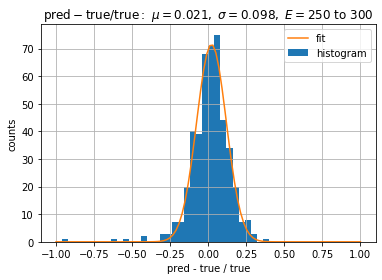

[0.02137131947269542, 0.09776617799745081, 0.0026808848040937236, 0.002680884808933861]
[1.64009909e-02 8.91264700e+01 8.48122701e-02] [0.0014641  1.33244694 0.0014641 ]


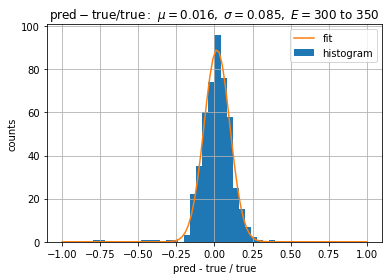

[0.016400990887161952, 0.08481227006015138, 0.0014641018586037597, 0.0014641018602966952]
[2.57786102e-02 6.85669246e+01 8.65357074e-02] [0.00236462 1.62259723 0.00236462]


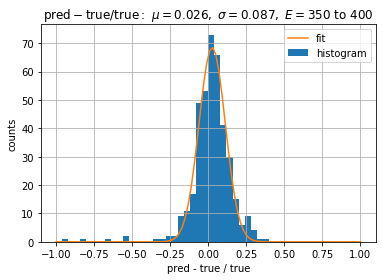

[0.025778610203549893, 0.08653570735520925, 0.0023646169295613597, 0.002364616928400211]
[1.87841542e-02 7.90842917e+01 8.27862335e-02] [0.00207225 1.7143745  0.00207225]


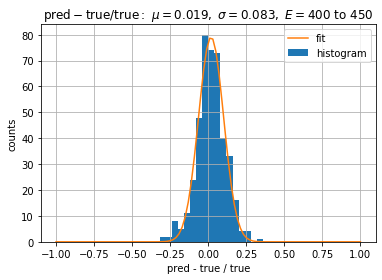

[0.018784154228308536, 0.08278623345035285, 0.002072253966949884, 0.0020722539659616505]
[2.72306428e-02 7.73449561e+01 7.90865661e-02] [0.00178382 1.51081384 0.00178382]


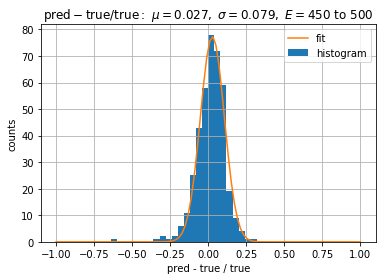

[0.027230642849952604, 0.07908656614673168, 0.0017838201578786342, 0.0017838201555846656]
[1.28380944e-02 7.71646357e+01 7.37130356e-02] [0.00176845 1.60323524 0.00176845]


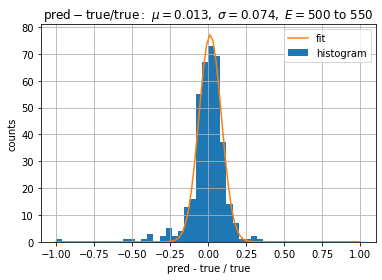

[0.012838094354611328, 0.07371303555287406, 0.0017684493645511643, 0.0017684493608341035]
[1.37098476e-02 9.48200112e+01 6.91516323e-02] [1.06744883e-03 1.26757959e+00 1.06744883e-03]


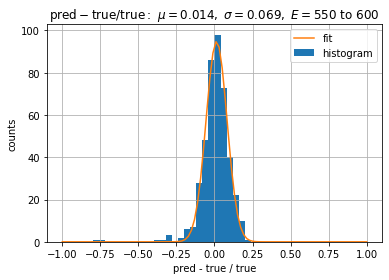

[0.013709847612531027, 0.06915163228390128, 0.0010674488283692622, 0.0010674488281635993]
[1.05052640e-02 7.84081653e+01 7.61744554e-02] [0.00214207 1.90948783 0.00214207]


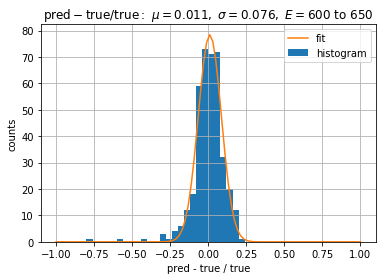

[0.010505263966504067, 0.07617445543635584, 0.002142073418222749, 0.002142073415784871]
[1.57838885e-02 7.74754086e+01 6.56581454e-02] [1.60260973e-03 1.63769735e+00 1.60260972e-03]


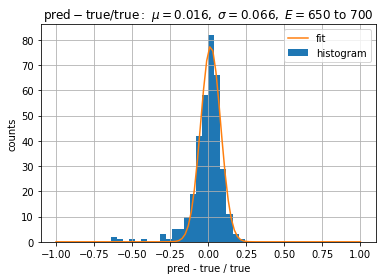

[0.01578388847736479, 0.0656581454410075, 0.0016026097293393167, 0.0016026097225001407]
[-5.75203037e-04  9.00873380e+01  7.16751280e-02] [1.28030722e-03 1.39360622e+00 1.28030722e-03]


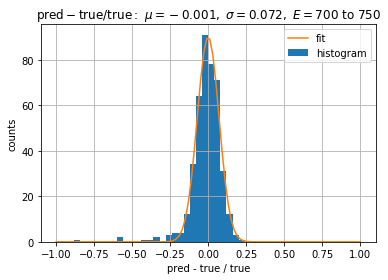

[-0.0005752030370287462, 0.07167512799476604, 0.0012803072201826747, 0.001280307217586021]
[-3.92472872e-03  1.03265926e+02  6.17481965e-02] [1.47480522e-03 2.13598425e+00 1.47480530e-03]


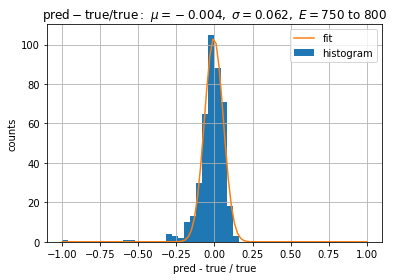

[-0.003924728720518898, 0.06174819648053542, 0.0014748052247013682, 0.0014748053038031346]
[-9.28602292e-03  1.00732044e+02  5.56028900e-02] [1.14828094e-03 1.80156157e+00 1.14828140e-03]


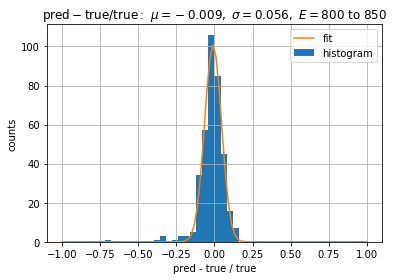

[-0.009286022924148133, 0.05560289003526639, 0.001148280936069325, 0.0011482813992861449]
[-2.42941414e-02  9.95966804e+01  5.58426864e-02] [1.06943571e-03 1.65182265e+00 1.06943311e-03]


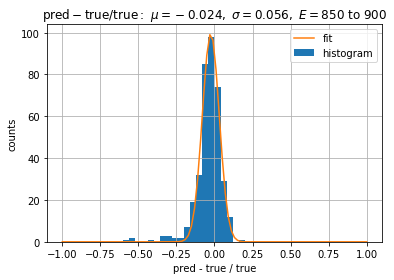

[-0.02429414137836678, 0.05584268642724915, 0.0010694357071233693, 0.0010694331129567165]
[-4.39223472e-02  9.87696117e+01  5.57661631e-02] [1.14686408e-03 1.75912056e+00 1.14686713e-03]


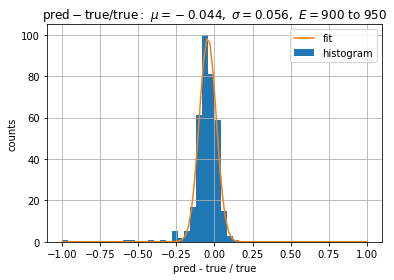

[-0.04392234721373894, 0.055766163066681945, 0.001146864080073323, 0.001146867126772943]
[-4.55350614e-02  1.14877509e+02  4.77072506e-02] [1.26405212e-03 2.63622170e+00 1.26429090e-03]


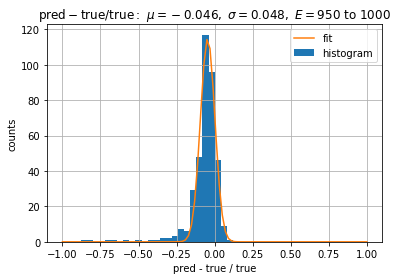

[-0.04553506138869489, 0.04770725062900234, 0.0012640521207609062, 0.0012642909043123775]
[0.37750137 0.24647548 0.20907078 0.15888237 0.14706154 0.15416544
 0.14308999 0.15130904 0.12951068 0.14077349 0.10247199 0.09776618
 0.08481227 0.08653571 0.08278623 0.07908657 0.07371304 0.06915163
 0.07617446 0.06565815 0.07167513 0.0617482  0.05560289 0.05584269
 0.05576616 0.04770725] 
 [0.03031007 0.0068397  0.00538494 0.00462625 0.00234017 0.00100437
 0.00264817 0.00249677 0.0028085  0.00167283 0.00264905 0.00268088
 0.0014641  0.00236462 0.00207225 0.00178382 0.00176845 0.00106745
 0.00214207 0.00160261 0.00128031 0.00147481 0.00114828 0.00106943
 0.00114687 0.00126429]


In [13]:
#bins =  np.linspace(0,1000,21)
#bins =  np.linspace(0,250,6)
bins =  np.linspace(0,200,11)
bins2 = np.linspace(250,1000,16)
bins = np.append(bins,bins2)
print(bins)

pred = np.array(pred)
true = np.array(true)
seoe = []
seoer = []
me = []
mer = []
for i in range (bins.size - 1):
    preda = pred[(true >bins[i]) & (true <bins[i+1]) ]
    truea = true[(true >bins[i]) & (true <bins[i+1]) ]
    vals = plotpred(preda,truea,bins[i],bins[i+1])
    print (vals)
    #seoe.append(vals[1]/bins[i+1])
    seoe.append(vals[1])
    seoer.append(vals[3])
    me.append(vals[0])
    mer.append(vals[2])
    #print (bins[i],bins[i+1])
seoear = np.array(seoe)
seoerar = np.array(seoer)
mear = np.array(me)
merar = np.array(mer)
print(seoear,'\n',seoerar)


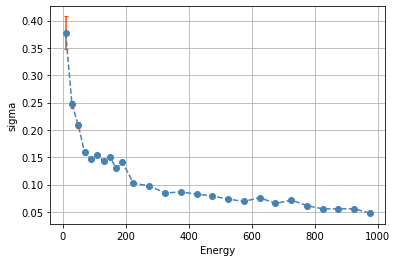

In [14]:
plotbinner = lambda t: t+10 if (t<200) else t+25
vfunc = np.vectorize(plotbinner)
newbin = vfunc(bins[:bins.size-1])
#plt.plot(bins[:5]+50,(seoear)*100,yerr=seoerar)
plt.errorbar(newbin,(seoear), yerr=seoerar, fmt='o', ecolor='orangered',color='steelblue', capsize=2,ls='--');
plt.xlabel('Energy')
plt.ylabel('sigma')
plt.grid(True)

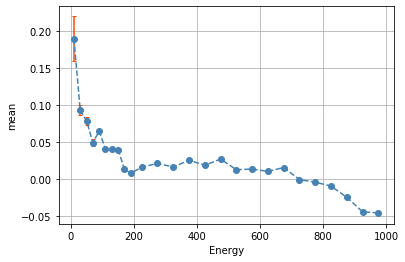

In [15]:
plt.errorbar(newbin,(mear), yerr=merar, fmt='o', ecolor='orangered',color='steelblue', capsize=2,ls='--');
plt.xlabel('Energy')
plt.ylabel('mean')
plt.grid(True)

[1.5876906  0.02193784] [0.04414856 0.00784941]
[1.5876906  0.02193784] 
 [[ 1.94909524e-03 -2.54592297e-04]
 [-2.54592297e-04  6.16132195e-05]]


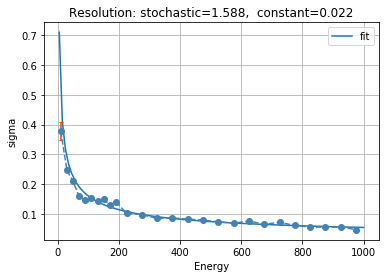

In [18]:

def reso(x,stoch,C):
#    return np.sqrt(stoch**2/x + e_dep**2/x**2 + C**2 )
    return np.sqrt(stoch**2/x  + C**2 )
 



popt, pcov = curve_fit(f=reso,xdata=newbin, ydata=seoear, sigma=seoerar, p0=[1.,1.],bounds = ([0,0],[np.inf,np.inf]))
perr = np.sqrt(np.diag(pcov))
print(popt,perr)

x_interval_for_fit = np.linspace(5,1000, 100)
plt.plot(x_interval_for_fit, reso(x_interval_for_fit, *popt), label='fit')
plt.errorbar(newbin,(seoear), yerr=seoerar, fmt='o', ecolor='orangered',color='steelblue', capsize=2,ls='--');
plt.legend()


plt.xlabel('Energy')
plt.ylabel('sigma')
#plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.title('Resolution: stochastic=%.3f,  constant=%.3f'%(popt[0], popt[1]))
print(popt,'\n',pcov)
plt.grid(True)

plt.show()

In [48]:

for data in tqdm(loader):
    model.eval()
    data = data.to('cuda')
    result=model(data)
    print(data.y)
    print(result)
    break

NameError: name 'loader' is not defined

In [ ]:
print(data_list[0].y)

#    cl = data_list[0].to('cuda')
#    cl.batch = torch.zeros(cl.x.shape[0], dtype=torch.int64).to('cuda:0')
#    val = model(cl)
#    print(val)
    #test(cl, batch).backward()
    #print(val)

In [ ]:
simentest= []
for i,data in tqdm(enumerate(testloader)):
    simentest.append(data.y.item())
    

In [ ]:
plt.hist(simentest, facecolor='green', alpha=0.75)
plt.xlabel('energy')
plt.title('Pion true energy')
plt.show()

In [57]:
torch.cuda.empty_cache()